<a href="https://colab.research.google.com/github/satoshibasaki/competition/blob/main/signate_46th_beginner_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 【第46回_Beginner限定コンペ】携帯電話の機能データからの価格帯分類


携帯電話の機能から販売価格を分類しよう！

## ライブラリの読み込み

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier

## データの読み込み

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
dir = "/content/drive/MyDrive/Data/signate_46th_begginer"
df_train_all = pd.read_csv(dir + '/train.csv')
df_test = pd.read_csv(dir + '/test.csv')
df_test_id = df_test["id"]
sample_submission = pd.read_csv(dir + '/sample_submission.csv')

テストデータセットとサンプルファイルのデータ数が合わない。

id=1 がサンプルには無いのが原因。

## データの前処理

In [14]:
# id は不要なので落とす
df_train_all = df_train_all.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

# ターゲット変数 y は分けておく
y = df_train_all["price_range"]
X = df_train_all.drop("price_range", axis=1)  # ここから特徴量は X, df_test に対して作成・追加する

### 新しい特徴量の作成・追加

In [15]:
# スクリーン面積: sc_area
X["sc_area"] = np.multiply(X["sc_h"], X["sc_w"])
df_test["sc_area"] = np.multiply(df_test["sc_h"], df_test["sc_w"])

# 画面比率: sc_ratio => NG (inf)
# X["sc_ratio"] = np.divide(X["sc_h"], X["sc_w"])
# df_test["sc_ratio"] = np.divide(df_test["sc_h"], df_test["sc_w"])

# 連続通信時間比: talk_time_ratio
# X["talk_time_ratio"] = X["talk_time"] / X["battery_power"]
# df_test["talk_time_ratio"] = df_test["talk_time"] / df_test["battery_power"]

# ピクセル密度: px_density => 値が大きすぎてNG (inf)
# X["px_density"] = np.divide(np.multiply(X["px_height"], X["px_width"]), X["sc_area"])
# df_test["px_density"] = np.divide(np.multiply(df_test["px_height"], df_test["px_width"]), df_test["sc_area"])

# プロセッサ速度指数: ps_idx
X["ps_idx"] = np.multiply(X["clock_speed"], X["n_cores"])
df_test["ps_idx"] = np.multiply(df_test["clock_speed"], df_test["n_cores"])

# コア当たりのRAM: ram_per_core
# X["ram_per_core"] = np.divide(X["ram"], X["n_cores"])
# df_test["ram_per_core"] = np.divide(df_test["ram"], df_test["n_cores"])

# メモリ効率: mem_eff
# X["mem_eff"] = np.divide(X["ram"], X["mobile_wt"])
# df_test["mem_eff"] = np.divide(df_test["ram"], df_test["mobile_wt"])

# ストレージ効率: str_eff
# X["str_eff"] = np.divide(X["int_memory"], X["mobile_wt"])
# df_test["str_eff"] = np.divide(df_test["int_memory"], df_test["mobile_wt"])

# バッテリー密度: bp_wt
# X["bp_wt"] = np.divide(X["battery_power"], X["mobile_wt"])
# df_test["bp_wt"] = np.divide(df_test["battery_power"], df_test["mobile_wt"])

# カメラ品質指数: cq_idx
X["cq_idx"] = X["pc"] + X["fc"]
df_test["cq_idx"] = df_test["pc"] + df_test["fc"]

# 通信機能数: conn_ft_cnt
X["conn_ft_cnt"] = X["blue"] + X["four_g"] + X["three_g"] + X["wifi"]
df_test["conn_ft_cnt"] = df_test["blue"] + df_test["four_g"] + df_test["three_g"] + df_test["wifi"]

# 全体の機能数: all_ft_cnt
X["all_ft_cnt"] = X["blue"] + X["dual_sim"]+ X["touch_screen"] + X["four_g"] + X["three_g"] + X["wifi"]
df_test["all_ft_cnt"] = df_test["blue"]+ df_test["dual_sim"]+ df_test["touch_screen"] + df_test["four_g"] + df_test["three_g"] + df_test["wifi"]

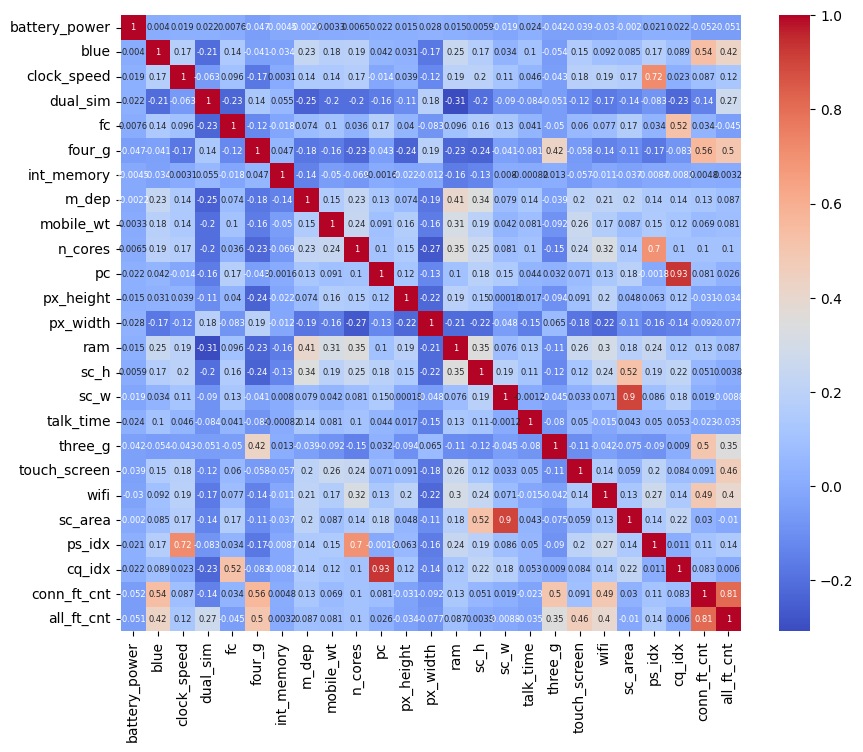

In [5]:
# 特徴量同士の相関関係を表示
corr = X.corr()
plt.figure(figsize=(10, 8))  # サイズを大きく設定
sns.heatmap(corr, annot=True, annot_kws={"size":6}, cmap='coolwarm')
plt.show()

### train データセットを訓練・検証データに分割

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 特徴量の尺度を揃える

In [18]:
std_columns = ['battery_power', 'clock_speed', 'fc',
        'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc',
        'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'sc_area',
        'ps_idx', 'cq_idx', 'conn_ft_cnt', 'all_ft_cnt',
        ]

# Standardize training data
sc = StandardScaler().fit(X_train[std_columns])
X_train[std_columns] = sc.transform(X_train[std_columns])

# Standardize validation data
X_valid[std_columns] = sc.transform(X_valid[std_columns])

# Standardize test data
df_test[std_columns] = sc.transform(df_test[std_columns])

## モデル作成とモデルの訓練

In [19]:
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
  """
  Evaluates a model on the training and validation sets.

  Args:
    model: The model to evaluate.
    X_train: The training data.
    y_train: The training labels.
    X_valid: The validation data.
    y_valid: The validation labels.

  Returns:
    A dictionary containing the training and validation accuracy and F1 macro scores.
  """

  # Train the model
  model.fit(X_train, y_train)

  # Predict on the training and validation sets
  pred_train = model.predict(X_train)
  pred_valid = model.predict(X_valid)

  # Calculate the accuracy and F1 macro scores
  train_acc = accuracy_score(y_train, pred_train)
  train_f1_macro = f1_score(y_train, pred_train, average='macro')
  valid_acc = accuracy_score(y_valid, pred_valid)
  valid_f1_macro = f1_score(y_valid, pred_valid, average='macro')

  # Return the results
  return {
      'train_acc': train_acc,
      'train_f1_macro': train_f1_macro,
      'valid_acc': valid_acc,
      'valid_f1_macro': valid_f1_macro
  }


In [29]:
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_results = evaluate_model(xgb, X_train, y_train, X_valid, y_valid)

print('XGB results:')
for metric, score in xgb_results.items():
    print(f"{metric}: {score:.4f}")

# SVM モデルの訓練
svm = SVC(C=1.0, kernel='rbf', probability=True, random_state=42)
svm_results = evaluate_model(svm, X_train, y_train, X_valid, y_valid)

print('\nSVM results:')
for metric, score in svm_results.items():
    print(f"{metric}: {score:.4f}")

# LightGBM モデルの訓練
lgb = LGBMClassifier(n_estimators=100, learning_rate=0.1, num_leaves=31, random_state=42, force_row_wise=True, verbose=0)
lgb_results = evaluate_model(lgb, X_train, y_train, X_valid, y_valid)

print('\nLGB results:')
for metric, score in lgb_results.items():
    print(f"{metric}: {score:.4f}")

XGB results:
train_acc: 1.0000
train_f1_macro: 1.0000
valid_acc: 0.5625
valid_f1_macro: 0.5288

SVM results:
train_acc: 0.6958
train_f1_macro: 0.6837
valid_acc: 0.5125
valid_f1_macro: 0.4774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGB results:
train_acc: 1.0000
train_f1_macro: 1.0000
valid_acc: 0.5208
valid_f1_macro: 0.4771


## それぞれのモデルをバギングを使ってアンアンブル学習してみる

In [33]:
xbg_bag = BaggingClassifier(estimator=xgb, random_state=42, n_jobs=-1)
xbg_bag_results = evaluate_model(xbg_bag, X_train, y_train, X_valid, y_valid)

print('XGB results:')
for metric, score in xbg_bag_results.items():
    print(f"{metric}: {score:.4f}")

svm_bag = BaggingClassifier(estimator=svm, random_state=42, n_jobs=-1)
svm_bag_results = evaluate_model(svm_bag, X_train, y_train, X_valid, y_valid)

print('\nSVM results:')
for metric, score in svm_bag_results.items():
    print(f"{metric}: {score:.4f}")

lgb_bag = BaggingClassifier(estimator=lgb, random_state=42, n_jobs=-1)
lgb_bag_results = evaluate_model(lgb_bag, X_train, y_train, X_valid, y_valid)

print('\nLGB results:')
for metric, score in lgb_bag_results.items():
    print(f"{metric}: {score:.4f}")

XGB results:
train_acc: 0.9865
train_f1_macro: 0.9857
valid_acc: 0.5292
valid_f1_macro: 0.4933

SVM results:
train_acc: 0.6958
train_f1_macro: 0.6643
valid_acc: 0.4833
valid_f1_macro: 0.3884

LGB results:
train_acc: 0.9844
train_f1_macro: 0.9831
valid_acc: 0.5375
valid_f1_macro: 0.5008


## VotingClassifier を使ってアンサンブル学習

In [27]:
estimators = [('xgb', xgb), ('smv', svm), ('lgb', lgb),]

vote = VotingClassifier(
    estimators=estimators,
    voting="soft",
    n_jobs=-1
)

vote_results = evaluate_model(vote, X_train, y_train, X_valid, y_valid)

print('\nvote results:')
for metric, score in vote_results.items():
    print(f"{metric}: {score:.4f}")


vote results:
train_acc: 1.0000
train_f1_macro: 1.0000
valid_acc: 0.5292
valid_f1_macro: 0.4858


## モデルの評価： テストデータを用いた推論

In [ ]:
# テストデータを用いた推論

pred_test = vote.predict(df_test)

pred_test = pred_test.astype(int)  # float => int
print(pred_test[:20])

[2 0 3 0 2 3 0 2 1 1 2 2 0 1 2 3 1 2 3 2]


In [ ]:
# submission ファイル作成

df_submission = pd.DataFrame({'id': df_test_id, 'price_range': pred_test})
df_submission.to_csv('submission.csv', index=False, header=None)